# Centrality Measures: Finding Important Nodes in Networks

---

## Learning Objectives

In this notebook, you will learn about different centrality measures and understand:
- **What is node importance?** Different definitions lead to different centrality measures
- **Degree centrality**: How many connections does a node have?
- **Betweenness centrality**: How often is a node on shortest paths?
- **Closeness centrality**: How close is a node to all others?
- **Eigenvector centrality**: Is a node connected to other important nodes?
- **PageRank**: Google's algorithm for ranking web pages
- **How to compare** different centrality measures
- **How to visualize** networks with centrality-based coloring

We'll use the **global airport network** as our example throughout this notebook.

---

## Introduction: What is Centrality?

In network analysis, we often want to identify the **most important** nodes. But "importance" can mean different things:

- **Most connected**: Nodes with many connections (Degree)
- **Best positioned**: Nodes that lie on many shortest paths (Betweenness)
- **Most accessible**: Nodes that can reach others quickly (Closeness)
- **Best connected**: Nodes connected to other important nodes (Eigenvector, PageRank)

Different centrality measures capture these different notions of importance!

In [ ]:
# Import libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Set style
plt.style.use('default')
%matplotlib inline

---

## Part 1: Load and Prepare the Airport Network

We'll use the same airport network from the previous class.

In [ ]:
# Load airport data
airport_columns = ["Airport ID", "Name", "City", "Country", "IATA", "ICAO",
                   "Latitude", "Longitude", "Altitude", "Timezone",
                   "DST", "TZ Database Timezone", "Type", "Source"]

route_columns = ["Airline", "Airline ID", "Source Airport", "Source Airport ID",
                 "Destination Airport", "Destination Airport ID", "Codeshare",
                 "Stops", "Equipment"]

airports_df = pd.read_csv("airports.csv", names=airport_columns, encoding="utf-8")
routes_df = pd.read_csv("routes.csv", names=route_columns, encoding="utf-8")

# Convert IDs to strings
airports_df['Airport ID'] = airports_df['Airport ID'].astype(str)
routes_df['Source Airport ID'] = routes_df['Source Airport ID'].astype(str)
routes_df['Destination Airport ID'] = routes_df['Destination Airport ID'].astype(str)

print(f"Loaded {len(airports_df)} airports and {len(routes_df)} routes")

Loaded 7698 airports and 31102 routes


In [ ]:
# Build the network (same as before)
airport_map = {
    row['Airport ID']: (row['Name'], row['IATA'], row['Latitude'], row['Longitude'])
    for _, row in airports_df.iterrows() if row['Type'] == 'airport'
}

routes_df_filtered = routes_df[
    routes_df['Source Airport ID'].isin(airport_map.keys()) &
    routes_df['Destination Airport ID'].isin(airport_map.keys())
]

# Create directed graph
G = nx.DiGraph()

for airport_id, (name, code, lat, lon) in airport_map.items():
    G.add_node(airport_id, name=name, code=code, latitude=lat, longitude=lon)

for _, row in routes_df_filtered.iterrows():
    source_id = row['Source Airport ID']
    destination_id = row['Destination Airport ID']
    G.add_edge(source_id, destination_id)

# Remove isolated nodes
isolated_nodes = [node for node, degree in dict(G.degree()).items() if degree == 0]
G.remove_nodes_from(isolated_nodes)

print(f"\nNetwork: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")


Network: 2325 nodes, 22949 edges


In [ ]:
# Get largest strongly connected component for centrality calculations
largest_scc = max(nx.strongly_connected_components(G), key=len)
G_main = G.subgraph(largest_scc).copy()

print(f"Largest strongly connected component: {G_main.number_of_nodes()} nodes")

Largest strongly connected component: 2285 nodes


---

## Part 2: Degree Centrality

The simplest centrality measure: **how many connections does a node have?**

For directed networks:
- **In-degree**: Number of incoming edges (how many airports fly TO this one)
- **Out-degree**: Number of outgoing edges (how many airports this one flies TO)
- **Total degree**: In-degree + Out-degree

In [ ]:
# Calculate degree centralities
in_degree = dict(G_main.in_degree())
out_degree = dict(G_main.out_degree())
total_degree = {node: in_degree[node] + out_degree[node] for node in G_main.nodes()}

# Get top 10 by total degree
top_10_degree = sorted(total_degree.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Airports by Total Degree:")
print("="*80)
for i, (airport_id, deg) in enumerate(top_10_degree, 1):
    name = G_main.nodes[airport_id]['name']
    code = G_main.nodes[airport_id]['code']
    in_deg = in_degree[airport_id]
    out_deg = out_degree[airport_id]
    print(f"{i:2d}. {name:40s} ({code}): {deg:4d} (in:{in_deg:4d}, out:{out_deg:4d})")

Top 10 Airports by Total Degree:
 1. Hartsfield Jackson Atlanta International Airport (ATL):  433 (in: 216, out: 217)
 2. Charles de Gaulle International Airport  (CDG):  372 (in: 186, out: 186)
 3. Dallas Fort Worth International Airport  (DFW):  367 (in: 183, out: 184)
 4. Beijing Capital International Airport    (PEK):  335 (in: 167, out: 168)
 5. Dubai International Airport              (DXB):  330 (in: 162, out: 168)
 6. London Heathrow Airport                  (LHR):  297 (in: 149, out: 148)
 7. John F Kennedy International Airport     (JFK):  295 (in: 147, out: 148)
 8. Dublin Airport                           (DUB):  282 (in: 141, out: 141)
 9. Chicago O'Hare International Airport     (ORD):  282 (in: 141, out: 141)
10. Charlotte Douglas International Airport  (CLT):  274 (in: 137, out: 137)


**Interpretation**: These are the most connected airports - they have direct flights to/from many other airports.

---

## Part 3: Betweenness Centrality

**How often does a node lie on shortest paths between other nodes?**

High betweenness centrality → the node is an important **bridge** or **connector** in the network.

For airports: Important transfer hubs have high betweenness.

In [ ]:
# Calculate betweenness centrality
print("Computing betweenness centrality... (this may take a minute)")
betweenness = nx.betweenness_centrality(G_main, normalized=True)
print("Done!")

# Get top 10
top_10_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 Airports by Betweenness Centrality:")
print("="*80)
for i, (airport_id, bc) in enumerate(top_10_betweenness, 1):
    name = G_main.nodes[airport_id]['name']
    code = G_main.nodes[airport_id]['code']
    deg = total_degree[airport_id]
    print(f"{i:2d}. {name:40s} ({code}): {bc:.6f} (degree: {deg})")

Computing betweenness centrality... (this may take a minute)
Done!

Top 10 Airports by Betweenness Centrality:
 1. Dubai International Airport              (DXB): 0.103551 (degree: 330)
 2. Charles de Gaulle International Airport  (CDG): 0.102267 (degree: 372)
 3. London Heathrow Airport                  (LHR): 0.075506 (degree: 297)
 4. Beijing Capital International Airport    (PEK): 0.071904 (degree: 335)
 5. Ted Stevens Anchorage International Airport (ANC): 0.070713 (degree: 64)
 6. Los Angeles International Airport        (LAX): 0.058183 (degree: 229)
 7. Hartsfield Jackson Atlanta International Airport (ATL): 0.056785 (degree: 433)
 8. Guarulhos - Governador André Franco Montoro International Airport (GRU): 0.049955 (degree: 141)
 9. Frankfurt am Main Airport                (FRA): 0.048122 (degree: 254)
10. Dallas Fort Worth International Airport  (DFW): 0.047279 (degree: 367)


### What does `normalized=True` mean in `nx.betweenness_centrality`?

When `normalized=True`, the betweenness centrality scores are scaled by a factor that depends on the number of nodes in the graph. This makes the centrality scores comparable across graphs of different sizes.

The normalization factor for an undirected graph with `n` nodes is `2 / ((n - 1)(n - 2))`. For a directed graph, it is `1 / ((n - 1)(n - 2))`.

**Why normalize?**
- **Comparison**: It allows you to compare the centrality of nodes in different networks, or in the same network if its size changes over time.
- **Interpretation**: The normalized score can be interpreted as the probability that a node lies on the shortest path between two randomly chosen nodes (when multiplied by `(n-1)(n-2)/2` for undirected graphs or `(n-1)(n-2)` for directed graphs).

If `normalized=False` (the default), the function returns the raw count of shortest paths that pass through each node, which can be very large for large graphs.

**Interpretation**: These airports are critical connectors. Removing them would significantly increase travel distances for many routes.

---

## Part 4: Closeness Centrality

**How close is a node to all other nodes?**

Closeness measures the average distance from a node to all others:
- High closeness → Can reach other airports quickly (few stops)
- Low closeness → Far from other airports (many stops needed)

$$C_{closeness}(i) = \frac{n-1}{\sum_{j \neq i} d(i,j)}$$

where $d(i,j)$ is the shortest path distance between nodes $i$ and $j$.

In [ ]:
# Calculate closeness centrality
print("Computing closeness centrality...")
closeness = nx.closeness_centrality(G_main)
print("Done!")

# Get top 10
top_10_closeness = sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 Airports by Closeness Centrality:")
print("="*80)
for i, (airport_id, cc) in enumerate(top_10_closeness, 1):
    name = G_main.nodes[airport_id]['name']
    code = G_main.nodes[airport_id]['code']
    deg = total_degree[airport_id]
    print(f"{i:2d}. {name:40s} ({code}): {cc:.6f} (degree: {deg})")

Computing closeness centrality...
Done!

Top 10 Airports by Closeness Centrality:
 1. Charles de Gaulle International Airport  (CDG): 0.419699 (degree: 372)
 2. London Heathrow Airport                  (LHR): 0.418392 (degree: 297)
 3. John F Kennedy International Airport     (JFK): 0.406550 (degree: 295)
 4. Dubai International Airport              (DXB): 0.406478 (degree: 330)
 5. Frankfurt am Main Airport                (FRA): 0.400631 (degree: 254)
 6. Los Angeles International Airport        (LAX): 0.394951 (degree: 229)
 7. Lester B. Pearson International Airport  (YYZ): 0.391968 (degree: 253)
 8. Amsterdam Airport Schiphol               (AMS): 0.391230 (degree: 219)
 9. Leonardo da Vinci–Fiumicino Airport      (FCO): 0.388435 (degree: 248)
10. Beijing Capital International Airport    (PEK): 0.385485 (degree: 335)


**Interpretation**: These airports are centrally located in the network structure and can reach other airports with the fewest connections.

---

## Part 5: Eigenvector Centrality

**Is a node connected to other important nodes?**

A node has high eigenvector centrality if:
- It's connected to many nodes, AND
- Those nodes are themselves important (high eigenvector centrality)

It's a **recursive** definition: your importance depends on the importance of your neighbors!

**Formula**: The eigenvector centrality satisfies:
$$x_i = \frac{1}{\lambda} \sum_{j} A_{ji} x_j$$

where $A$ is the adjacency matrix and $\lambda$ is the largest eigenvalue.

In [ ]:
# Calculate eigenvector centrality
print("Computing eigenvector centrality...")
try:
    eigenvector = nx.eigenvector_centrality(G_main, max_iter=1000)
    print("Done!")

    # Get top 10
    top_10_eigenvector = sorted(eigenvector.items(), key=lambda x: x[1], reverse=True)[:10]

    print("\nTop 10 Airports by Eigenvector Centrality:")
    print("="*80)
    for i, (airport_id, ec) in enumerate(top_10_eigenvector, 1):
        name = G_main.nodes[airport_id]['name']
        code = G_main.nodes[airport_id]['code']
        deg = total_degree[airport_id]
        print(f"{i:2d}. {name:40s} ({code}): {ec:.6f} (degree: {deg})")
except:
    print("Eigenvector centrality did not converge. This can happen with directed graphs.")
    print("We'll use PageRank instead, which is more robust for directed networks.")
    eigenvector = None

Computing eigenvector centrality...
Done!

Top 10 Airports by Eigenvector Centrality:
 1. Hartsfield Jackson Atlanta International Airport (ATL): 0.171331 (degree: 433)
 2. Charles de Gaulle International Airport  (CDG): 0.170088 (degree: 372)
 3. John F Kennedy International Airport     (JFK): 0.166532 (degree: 295)
 4. London Heathrow Airport                  (LHR): 0.165965 (degree: 297)
 5. Dallas Fort Worth International Airport  (DFW): 0.145036 (degree: 367)
 6. Chicago O'Hare International Airport     (ORD): 0.144798 (degree: 282)
 7. Lester B. Pearson International Airport  (YYZ): 0.138038 (degree: 253)
 8. Philadelphia International Airport       (PHL): 0.133766 (degree: 241)
 9. Los Angeles International Airport        (LAX): 0.131760 (degree: 229)
10. Detroit Metropolitan Wayne County Airport (DTW): 0.130349 (degree: 267)


**Interpretation**: These airports are connected to other well-connected airports in the network.

---

## Part 6: PageRank

**Google's algorithm for ranking web pages!**

PageRank is similar to eigenvector centrality but:
1. Designed specifically for **directed networks**
2. Includes a "damping factor" (random jump probability)
3. More robust and always converges

**Key concept**: A node is important if important nodes point to it.


In [ ]:
# Calculate PageRank on REVERSED graph
print("Computing PageRank...")
G_reversed = G_main.reverse()
pagerank = nx.pagerank(G_reversed, alpha=0.85)
print("Done!")

# Get top 10
top_10_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 Airports by PageRank:")
print("="*80)
for i, (airport_id, pr) in enumerate(top_10_pagerank, 1):
    name = G_main.nodes[airport_id]['name']
    code = G_main.nodes[airport_id]['code']
    deg = total_degree[airport_id]
    in_deg = in_degree[airport_id]
    print(f"{i:2d}. {name:40s} ({code}): {pr:.6f} (in-degree: {in_deg})")

Computing PageRank...
Done!

Top 10 Airports by PageRank:
 1. Hartsfield Jackson Atlanta International Airport (ATL): 0.008088 (in-degree: 216)
 2. Dallas Fort Worth International Airport  (DFW): 0.007431 (in-degree: 183)
 3. Dubai International Airport              (DXB): 0.006572 (in-degree: 162)
 4. Charles de Gaulle International Airport  (CDG): 0.005893 (in-degree: 186)
 5. Beijing Capital International Airport    (PEK): 0.005549 (in-degree: 167)
 6. Chicago O'Hare International Airport     (ORD): 0.004935 (in-degree: 141)
 7. Minneapolis-St Paul International/Wold-Chamberlain Airport (MSP): 0.004818 (in-degree: 128)
 8. John F Kennedy International Airport     (JFK): 0.004762 (in-degree: 147)
 9. El Dorado International Airport          (BOG): 0.004728 (in-degree: 74)
10. Lester B. Pearson International Airport  (YYZ): 0.004689 (in-degree: 126)


**Interpretation**: These are airports that many other airports fly to, especially if those other airports are themselves important hubs.

---

## Part 7: Comparing Centrality Measures

Let's compare all centrality measures to understand what each one captures.

### 7.1 Create Comparison Table

In [ ]:
# Create comprehensive comparison DataFrame
centrality_df = pd.DataFrame({
    'Airport_ID': list(G_main.nodes()),
    'Name': [G_main.nodes[n]['name'] for n in G_main.nodes()],
    'Code': [G_main.nodes[n]['code'] for n in G_main.nodes()],
    'Degree': [total_degree[n] for n in G_main.nodes()],
    'In-Degree': [in_degree[n] for n in G_main.nodes()],
    'Out-Degree': [out_degree[n] for n in G_main.nodes()],
    'Betweenness': [betweenness[n] for n in G_main.nodes()],
    'Closeness': [closeness[n] for n in G_main.nodes()],
    'PageRank': [pagerank[n] for n in G_main.nodes()]
})

if eigenvector is not None:
    centrality_df['Eigenvector'] = [eigenvector[n] for n in G_main.nodes()]

print("Sample of centrality data:")
print(centrality_df.head(10))

Sample of centrality data:
  Airport_ID                                         Name Code  Degree  \
0          1                               Goroka Airport  GKA       8   
1          2                               Madang Airport  MAG       8   
2          3                 Mount Hagen Kagamuga Airport  HGU      17   
3          4                               Nadzab Airport  LAE      18   
4          5  Port Moresby Jacksons International Airport  POM      25   
5          6                  Wewak International Airport  WWK       4   
6          7                           Narsarsuaq Airport  UAK      10   
7          8                      Godthaab / Nuuk Airport  GOH      14   
8          9                        Kangerlussuaq Airport  SFJ      14   
9         10                               Thule Air Base  THU       2   

   In-Degree  Out-Degree  Betweenness  Closeness  PageRank   Eigenvector  
0          4           4     0.000290   0.199703  0.000403  6.542052e-06  
1       

In [ ]:
# Show top 15 airports by each measure
print("\n" + "="*100)
print("TOP 15 AIRPORTS BY DIFFERENT CENTRALITY MEASURES")
print("="*100)

measures = ['Degree', 'Betweenness', 'Closeness', 'PageRank']
if eigenvector is not None:
    measures.append('Eigenvector')

for measure in measures:
    print(f"\n{measure.upper()}:")
    print("-" * 80)
    top_15 = centrality_df.nlargest(15, measure)[['Name', 'Code', measure]]
    for i, (_, row) in enumerate(top_15.iterrows(), 1):
        print(f"{i:2d}. {row['Name']:40s} ({row['Code']:3s}): {row[measure]:.6f}")


TOP 15 AIRPORTS BY DIFFERENT CENTRALITY MEASURES

DEGREE:
--------------------------------------------------------------------------------
 1. Hartsfield Jackson Atlanta International Airport (ATL): 433.000000
 2. Charles de Gaulle International Airport  (CDG): 372.000000
 3. Dallas Fort Worth International Airport  (DFW): 367.000000
 4. Beijing Capital International Airport    (PEK): 335.000000
 5. Dubai International Airport              (DXB): 330.000000
 6. London Heathrow Airport                  (LHR): 297.000000
 7. John F Kennedy International Airport     (JFK): 295.000000
 8. Dublin Airport                           (DUB): 282.000000
 9. Chicago O'Hare International Airport     (ORD): 282.000000
10. Charlotte Douglas International Airport  (CLT): 274.000000
11. Detroit Metropolitan Wayne County Airport (DTW): 267.000000
12. Guangzhou Baiyun International Airport   (CAN): 265.000000
13. London Stansted Airport                  (STN): 264.000000
14. Minneapolis-St Paul Internat

### 7.2 Correlation Analysis

How correlated are different centrality measures? Do they identify the same airports as important?

In [ ]:
# Calculate correlation matrix
correlation_cols = ['Degree', 'Betweenness', 'Closeness', 'PageRank']
if eigenvector is not None:
    correlation_cols.append('Eigenvector')

correlation_matrix = centrality_df[correlation_cols].corr()

print("Correlation Matrix of Centrality Measures:")
print(correlation_matrix.round(3))

Correlation Matrix of Centrality Measures:
             Degree  Betweenness  Closeness  PageRank  Eigenvector
Degree        1.000        0.746      0.616     0.955        0.928
Betweenness   0.746        1.000      0.403     0.821        0.672
Closeness     0.616        0.403      1.000     0.539        0.683
PageRank      0.955        0.821      0.539     1.000        0.850
Eigenvector   0.928        0.672      0.683     0.850        1.000


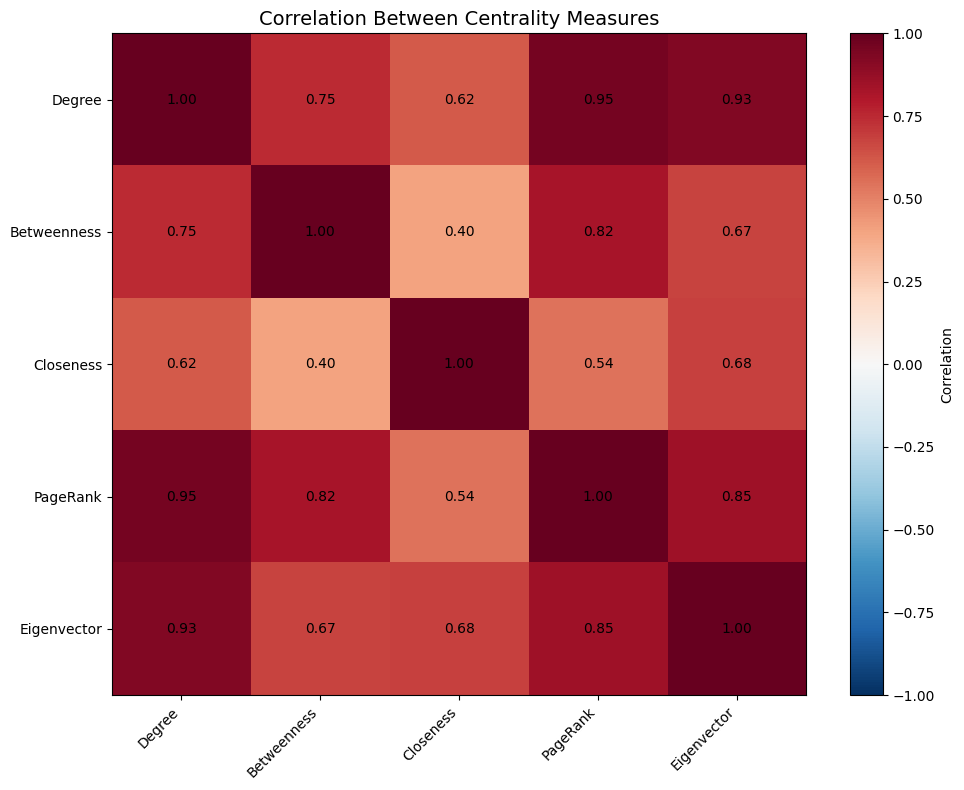

In [ ]:
# Visualize correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
plt.colorbar(label='Correlation')
plt.xticks(range(len(correlation_cols)), correlation_cols, rotation=45, ha='right')
plt.yticks(range(len(correlation_cols)), correlation_cols)
plt.title('Correlation Between Centrality Measures', fontsize=14)

# Add correlation values as text
for i in range(len(correlation_cols)):
    for j in range(len(correlation_cols)):
        plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                ha='center', va='center', color='black', fontsize=10)

plt.tight_layout()
plt.show()

**Interpretation**:
- High correlation (>0.8): Measures identify similar airports
- Low correlation (<0.5): Measures capture different aspects of importance

### 7.3 Scatter Plot Comparisons

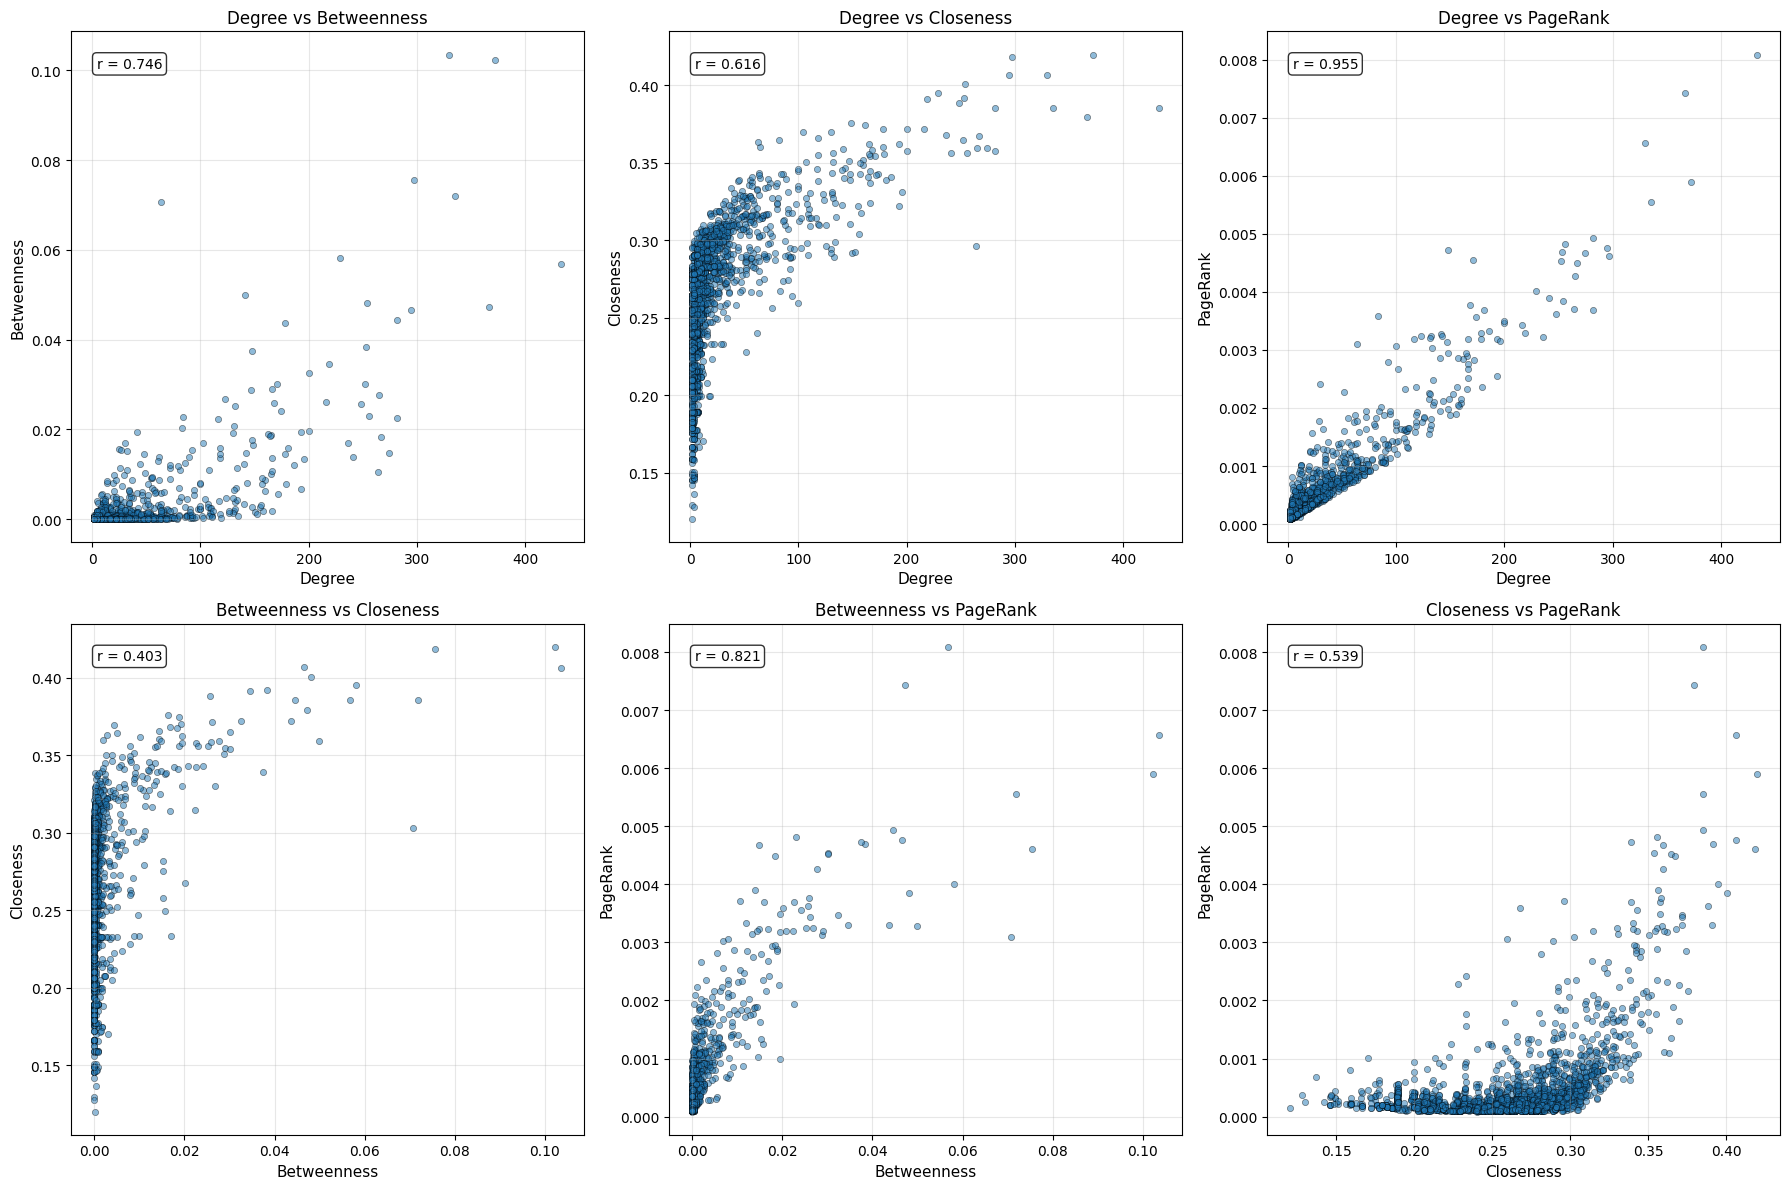

In [ ]:
# Create scatter plots comparing different measures
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

comparisons = [
    ('Degree', 'Betweenness'),
    ('Degree', 'Closeness'),
    ('Degree', 'PageRank'),
    ('Betweenness', 'Closeness'),
    ('Betweenness', 'PageRank'),
    ('Closeness', 'PageRank')
]

for idx, (x_var, y_var) in enumerate(comparisons):
    axes[idx].scatter(centrality_df[x_var], centrality_df[y_var],
                     alpha=0.5, s=20, edgecolors='k', linewidth=0.5)
    axes[idx].set_xlabel(x_var, fontsize=11)
    axes[idx].set_ylabel(y_var, fontsize=11)
    axes[idx].set_title(f'{x_var} vs {y_var}', fontsize=12)
    axes[idx].grid(alpha=0.3)

    # Add correlation coefficient
    corr = centrality_df[[x_var, y_var]].corr().iloc[0, 1]
    axes[idx].text(0.05, 0.95, f'r = {corr:.3f}',
                  transform=axes[idx].transAxes,
                  fontsize=10, verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

**Key observations**:
- Look for outliers: airports high in one measure but low in another
- These reveal different roles in the network!

### 7.4 Identifying Different Types of Hubs

In [ ]:
# Find airports with high betweenness but relatively lower degree
# These are important "bridge" airports

# Normalize both measures to 0-1 scale
centrality_df['Degree_norm'] = (centrality_df['Degree'] - centrality_df['Degree'].min()) / \
                                (centrality_df['Degree'].max() - centrality_df['Degree'].min())
centrality_df['Betweenness_norm'] = (centrality_df['Betweenness'] - centrality_df['Betweenness'].min()) / \
                                     (centrality_df['Betweenness'].max() - centrality_df['Betweenness'].min())

# Find airports where betweenness is much higher than degree
centrality_df['Bridge_score'] = centrality_df['Betweenness_norm'] - centrality_df['Degree_norm']

# Top bridge airports
bridge_airports = centrality_df.nlargest(15, 'Bridge_score')

print("Top 15 'Bridge' Airports (High Betweenness relative to Degree):")
print("="*90)
print(f"{'Airport':<40} {'Code':<5} {'Degree':<8} {'Betweenness':<12} {'Bridge Score'}")
print("="*90)

for _, row in bridge_airports.iterrows():
    print(f"{row['Name']:<40} {row['Code']:<5} {row['Degree']:<8} "
          f"{row['Betweenness']:<12.6f} {row['Bridge_score']:.4f}")

Top 15 'Bridge' Airports (High Betweenness relative to Degree):
Airport                                  Code  Degree   Betweenness  Bridge Score
Ted Stevens Anchorage International Airport ANC   64       0.070713     0.5390
Dubai International Airport              DXB   330      0.103551     0.2390
Guarulhos - Governador André Franco Montoro International Airport GRU   141      0.049955     0.1599
Charles de Gaulle International Airport  CDG   372      0.102267     0.1291
Bethel Airport                           BET   30       0.016997     0.0992
Port Moresby Jacksons International Airport POM   25       0.015671     0.0980
Brisbane International Airport           BNE   41       0.019412     0.0970
Fairbanks International Airport          FAI   27       0.015306     0.0898
Yellowknife Airport                      YZF   32       0.015137     0.0766
El Alto International Airport            LPB   14       0.008481     0.0541
Ndjili International Airport             FIH   26       0.01126

**Interpretation**: These airports may not have the most connections, but they play critical roles in connecting different regions of the network!

---

## Part 8: Network Visualization with Centrality-Based Coloring

Let's visualize the network with nodes colored by different centrality measures.

### 8.1 Prepare Subgraph for Visualization

In [ ]:
# Use top 150 airports by degree for clearer visualization
top_150_airports = centrality_df.nlargest(150, 'Degree')['Airport_ID'].tolist()
G_viz = G_main.subgraph(top_150_airports).copy()

# Create layout (we'll reuse this for all plots)
print("Computing layout...")
pos = nx.spring_layout(G_viz, seed=42, k=0.5, iterations=50)
print("Done!")

Computing layout...
Done!


### 8.2 Visualization by Degree

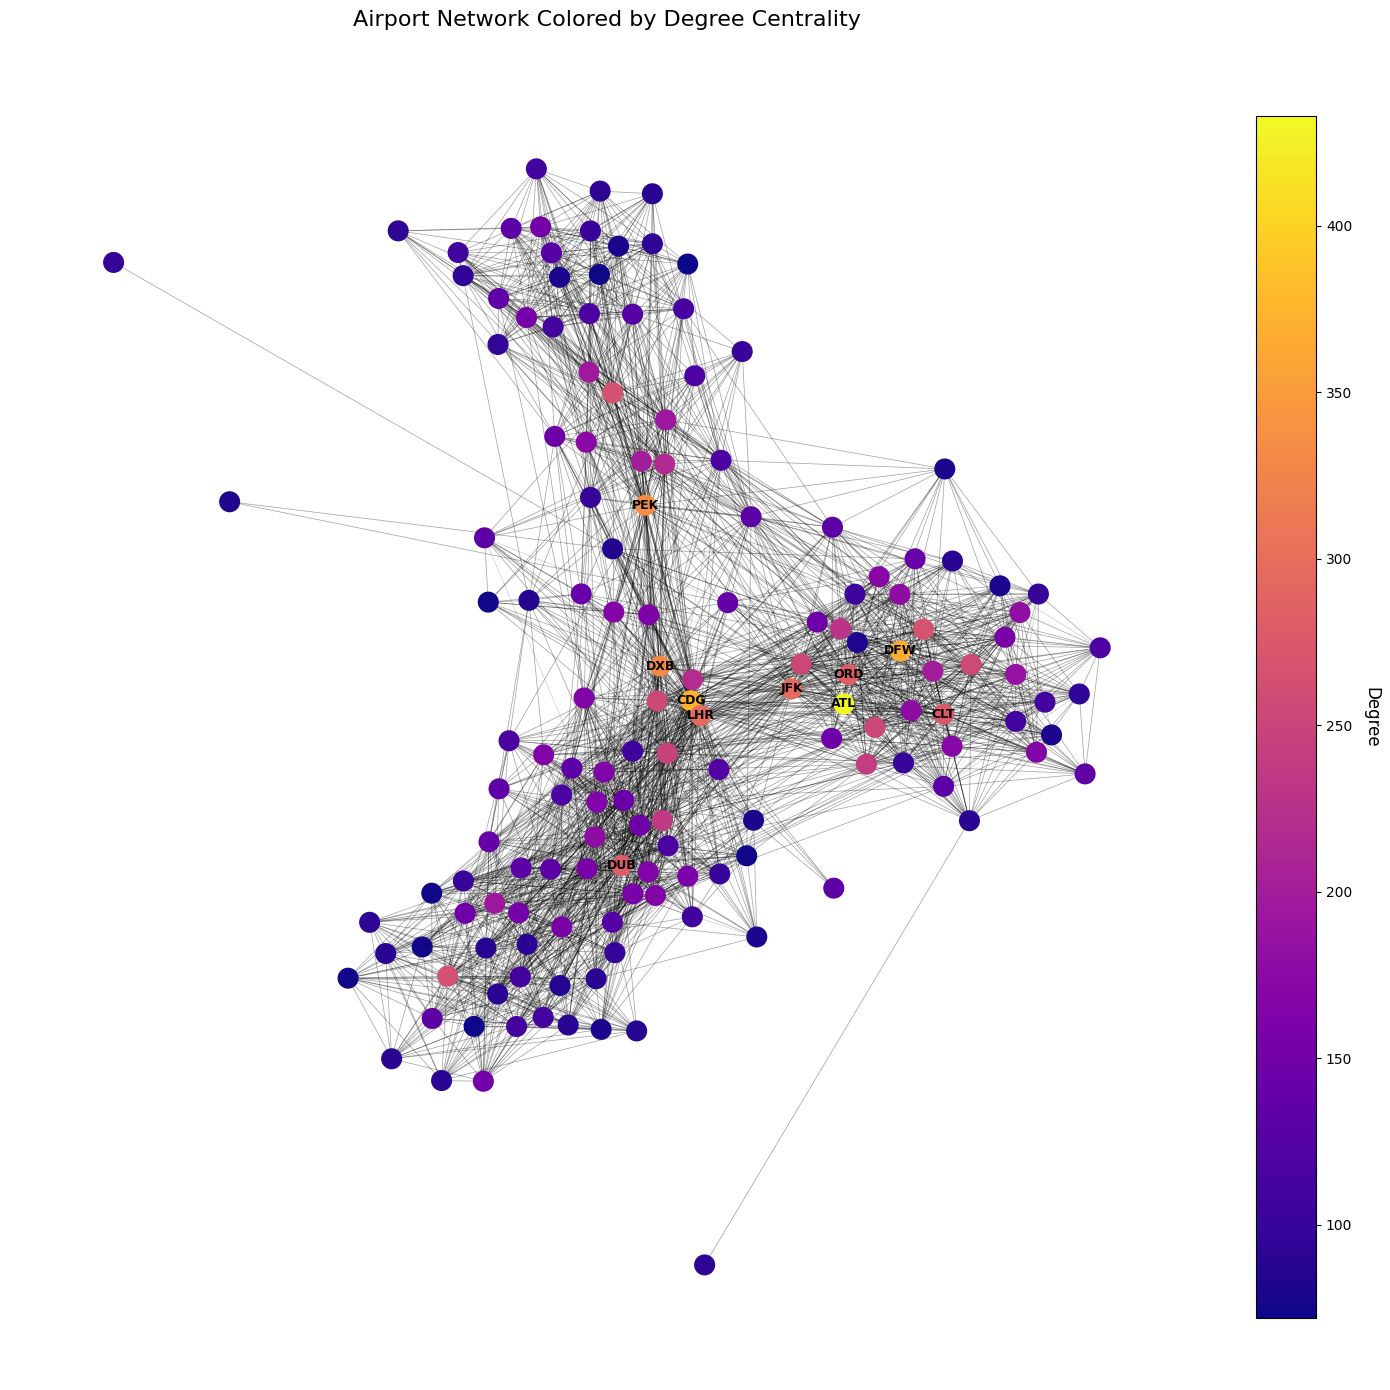

In [ ]:
# Prepare data for degree visualization
degree_values = np.array([total_degree[n] for n in G_viz.nodes()])
degree_normalized = (degree_values - degree_values.min()) / (degree_values.max() - degree_values.min())

# Plot
plt.figure(figsize=(14, 14))
nx.draw_networkx_edges(G_viz, pos, alpha=0.2, width=0.5, arrows=False)
nx.draw_networkx_nodes(G_viz, pos, node_size=200,
                       node_color=degree_normalized,
                       cmap=plt.cm.plasma,
                       vmin=0, vmax=1)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma,
                           norm=plt.Normalize(vmin=degree_values.min(),
                                            vmax=degree_values.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), fraction=0.046, pad=0.04)
cbar.set_label('Degree', rotation=270, labelpad=20, fontsize=12)

# Label top 10 airports
top_10_viz = sorted([(n, total_degree[n]) for n in G_viz.nodes()],
                    key=lambda x: x[1], reverse=True)[:10]
labels = {n: G_viz.nodes[n]['code'] for n, _ in top_10_viz}
nx.draw_networkx_labels(G_viz, pos, labels, font_size=9, font_weight='bold')

plt.title('Airport Network Colored by Degree Centrality', fontsize=16, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

### 8.3 Visualization by Betweenness

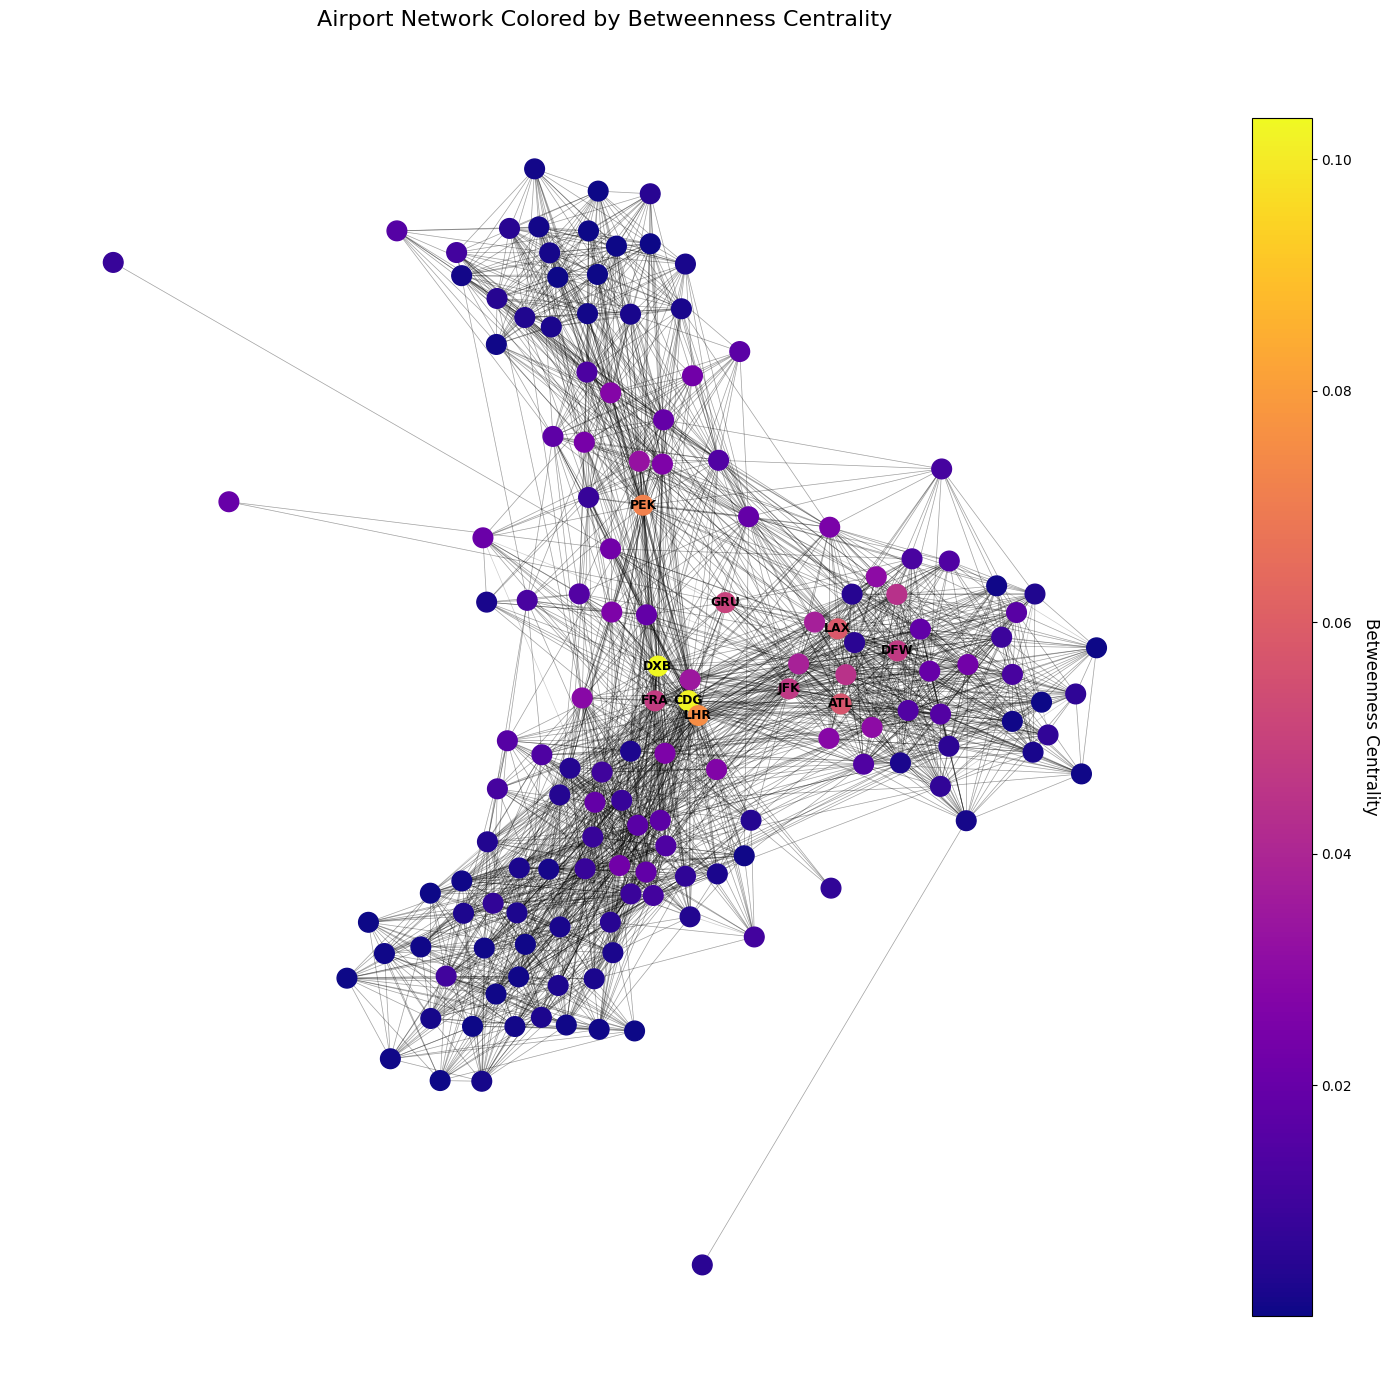

In [ ]:
# Prepare data for betweenness visualization
betweenness_values = np.array([betweenness[n] for n in G_viz.nodes()])
betweenness_normalized = (betweenness_values - betweenness_values.min()) / \
                         (betweenness_values.max() - betweenness_values.min())

# Plot
plt.figure(figsize=(14, 14))
nx.draw_networkx_edges(G_viz, pos, alpha=0.2, width=0.5, arrows=False)
nx.draw_networkx_nodes(G_viz, pos, node_size=200,
                       node_color=betweenness_normalized,
                       cmap=plt.cm.plasma,
                       vmin=0, vmax=1)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma,
                           norm=plt.Normalize(vmin=betweenness_values.min(),
                                            vmax=betweenness_values.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), fraction=0.046, pad=0.04)
cbar.set_label('Betweenness Centrality', rotation=270, labelpad=20, fontsize=12)

# Label top 10 airports by betweenness
top_10_between = sorted([(n, betweenness[n]) for n in G_viz.nodes()],
                        key=lambda x: x[1], reverse=True)[:10]
labels = {n: G_viz.nodes[n]['code'] for n, _ in top_10_between}
nx.draw_networkx_labels(G_viz, pos, labels, font_size=9, font_weight='bold')

plt.title('Airport Network Colored by Betweenness Centrality', fontsize=16, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

### 8.4 Visualization by PageRank

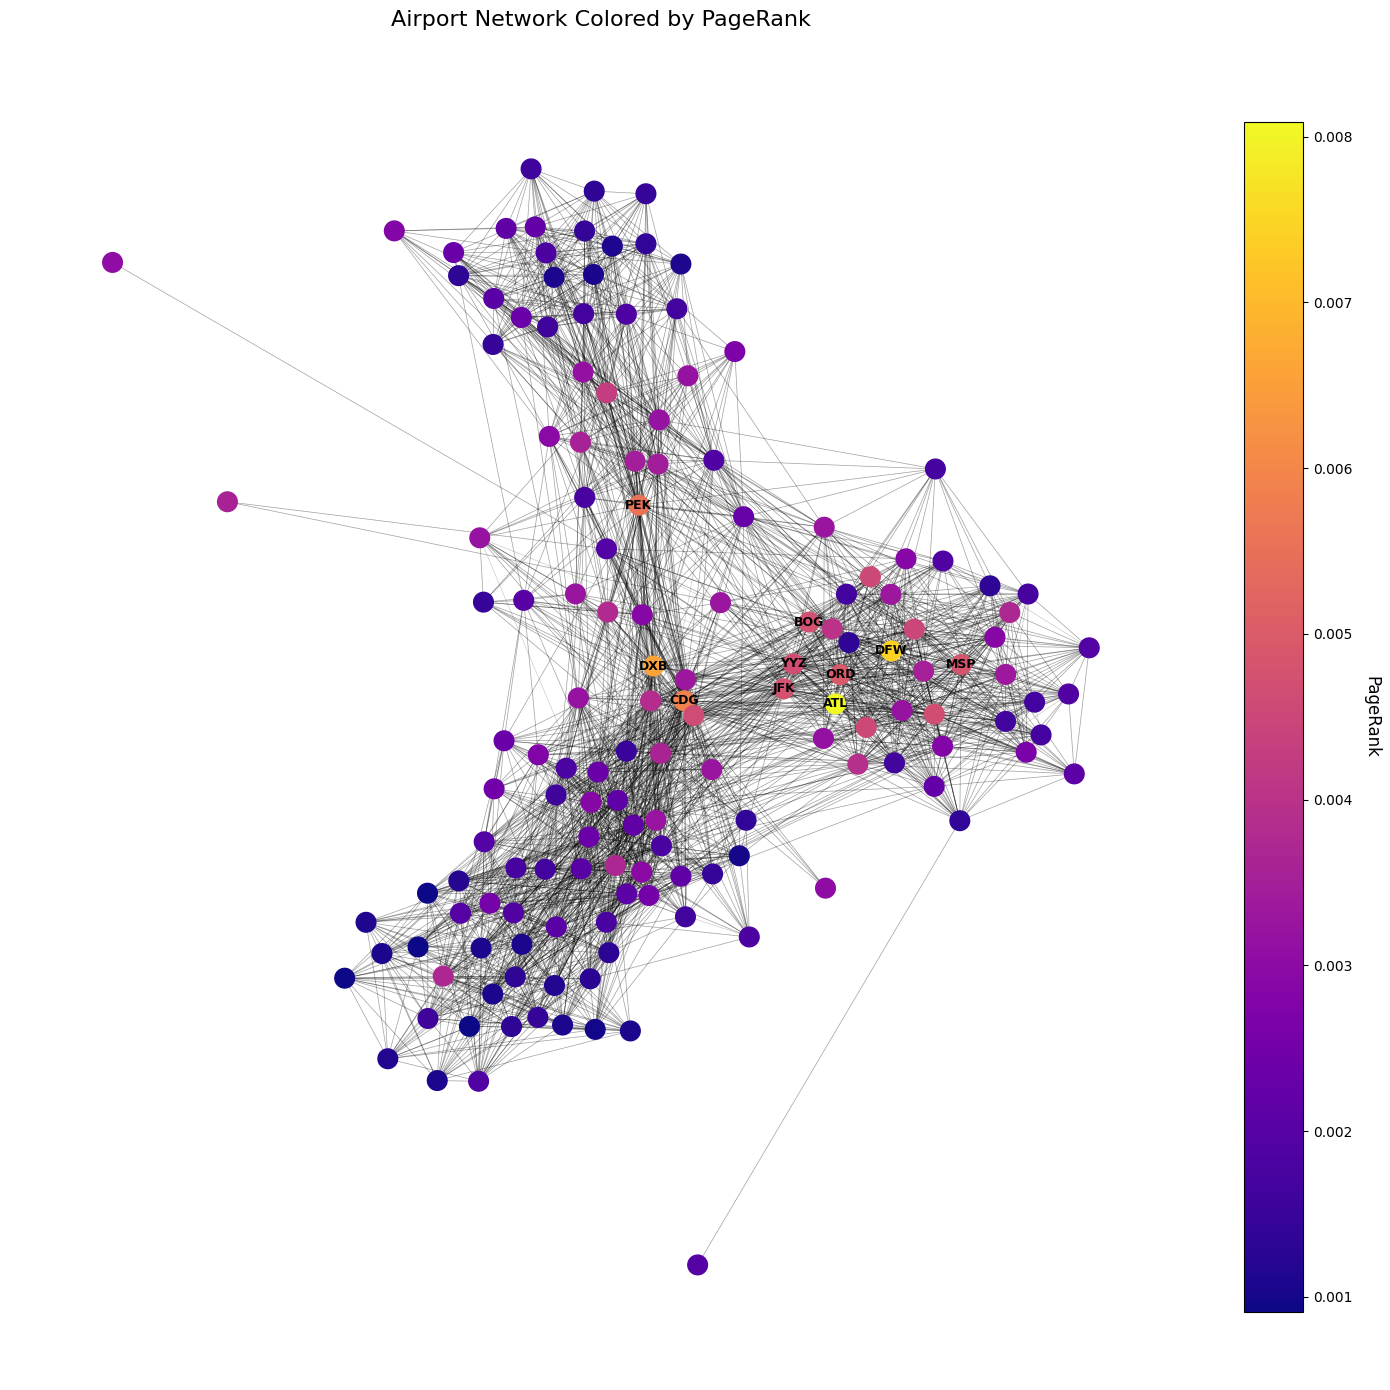

In [ ]:
# Prepare data for PageRank visualization
pagerank_values = np.array([pagerank[n] for n in G_viz.nodes()])
pagerank_normalized = (pagerank_values - pagerank_values.min()) / \
                      (pagerank_values.max() - pagerank_values.min())

# Plot
plt.figure(figsize=(14, 14))
nx.draw_networkx_edges(G_viz, pos, alpha=0.2, width=0.5, arrows=False)
nx.draw_networkx_nodes(G_viz, pos, node_size=200,
                       node_color=pagerank_normalized,
                       cmap=plt.cm.plasma,
                       vmin=0, vmax=1)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma,
                           norm=plt.Normalize(vmin=pagerank_values.min(),
                                            vmax=pagerank_values.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), fraction=0.046, pad=0.04)
cbar.set_label('PageRank', rotation=270, labelpad=20, fontsize=12)

# Label top 10 airports by PageRank
top_10_pr = sorted([(n, pagerank[n]) for n in G_viz.nodes()],
                   key=lambda x: x[1], reverse=True)[:10]
labels = {n: G_viz.nodes[n]['code'] for n, _ in top_10_pr}
nx.draw_networkx_labels(G_viz, pos, labels, font_size=9, font_weight='bold')

plt.title('Airport Network Colored by PageRank', fontsize=16, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

### 8.5 Side-by-Side Comparison

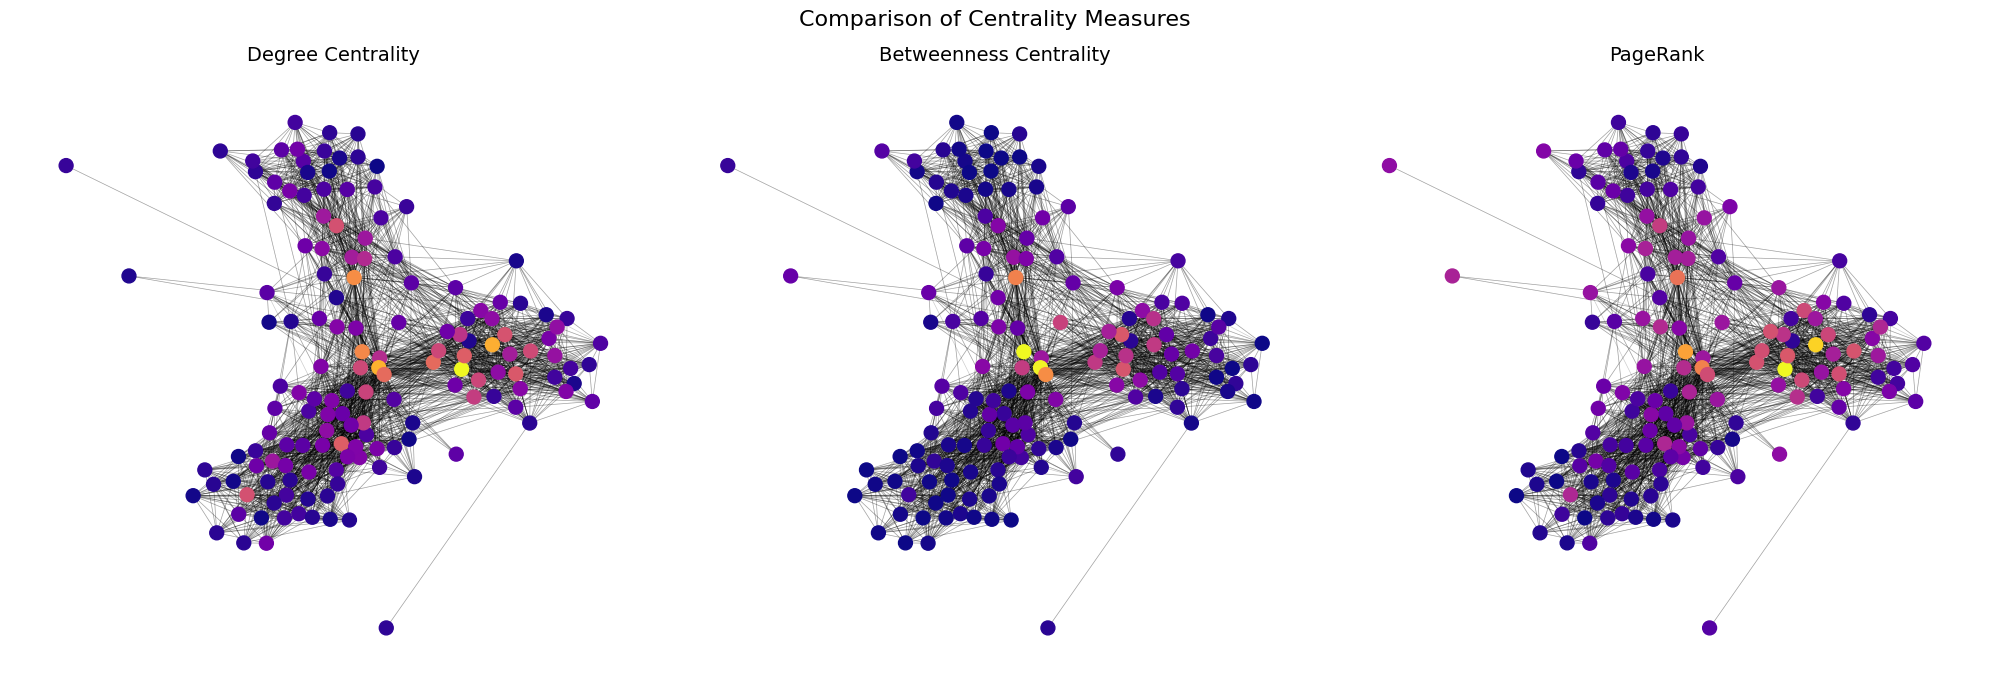

In [ ]:
# Create side-by-side comparison
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# Degree
nx.draw_networkx_edges(G_viz, pos, alpha=0.2, width=0.5, arrows=False, ax=axes[0])
nx.draw_networkx_nodes(G_viz, pos, node_size=100,
                       node_color=degree_normalized,
                       cmap=plt.cm.plasma, vmin=0, vmax=1, ax=axes[0])
axes[0].set_title('Degree Centrality', fontsize=14)
axes[0].axis('off')

# Betweenness
nx.draw_networkx_edges(G_viz, pos, alpha=0.2, width=0.5, arrows=False, ax=axes[1])
nx.draw_networkx_nodes(G_viz, pos, node_size=100,
                       node_color=betweenness_normalized,
                       cmap=plt.cm.plasma, vmin=0, vmax=1, ax=axes[1])
axes[1].set_title('Betweenness Centrality', fontsize=14)
axes[1].axis('off')

# PageRank
nx.draw_networkx_edges(G_viz, pos, alpha=0.2, width=0.5, arrows=False, ax=axes[2])
nx.draw_networkx_nodes(G_viz, pos, node_size=100,
                       node_color=pagerank_normalized,
                       cmap=plt.cm.plasma, vmin=0, vmax=1, ax=axes[2])
axes[2].set_title('PageRank', fontsize=14)
axes[2].axis('off')

plt.suptitle('Comparison of Centrality Measures', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

---

## Summary: Choosing the Right Centrality Measure

| Centrality Measure | What it measures | When to use it | Example interpretation (Airports) |
|-------------------|------------------|----------------|-----------------------------------|
| **Degree** | Number of connections | Direct connectivity | Most destinations you can fly to |
| **Betweenness** | How often on shortest paths | Identifying bridges/bottlenecks | Critical transfer hubs |
| **Closeness** | Average distance to others | Accessibility | Airports requiring fewest connections |
| **Eigenvector** | Connected to important nodes | Prestige/status | Well-connected to other major hubs |
| **PageRank** | Like eigenvector, for directed | Influence/importance | Airports many others fly to |

### Key Takeaways:

1. **No single "best" centrality**: Different measures capture different aspects of importance
2. **Use multiple measures**: Get a more complete picture of network structure
3. **Look for outliers**: Nodes high in one measure but low in others play unique roles
4. **Consider your question**: What type of "importance" matters for your analysis?
5. **Directed vs undirected**: Some measures require adaptation for directed networks

---

**You're now ready to apply centrality analysis to other networks! Next up: the U.S. Congress influence network.**